Total number of variables............................:       36
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:       36
        inequality constraints with only lower bounds:       20
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       16


Number of Iterations....: 33

                                   (scaled)                 (unscaled)
Objective...............:   2.6571520405005467e+03    2.6571520405005467e+03
Dual infeasibility......:   4.0429881664749701e-12    4.0429881664749701e-12
Constraint violation....:   1.7763568394002505e-15    1.7763568394002505e-15
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementari

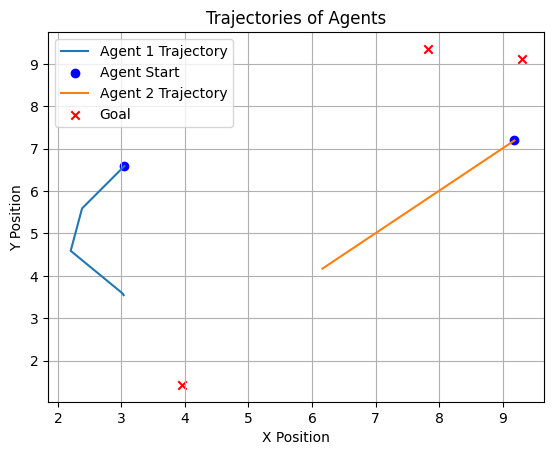

In [36]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

def softmin_casadi(x, alpha=1):
    return -1 / alpha * ca.log(ca.sum1(ca.exp(-alpha * x + 1e-17)))

def softmax_casadi(x, alpha=1):
    return ca.exp(alpha * x) / ca.sum1(ca.exp(alpha * x))

def compute_distance(robot_position, goal_positions):
    return ca.sqrt(ca.sum1((robot_position - goal_positions) ** 2)).T

def compute_evidence(robot_position, goal_positions, eta=10):
    evidence = compute_distance(robot_position, goal_positions)
    return eta * ca.exp(-1.0 / eta * evidence)

def compute_entropy(evidence):
    likelihood = softmax_casadi(evidence)
    total_cost = -ca.mtimes(likelihood.T, ca.log(likelihood))
    return total_cost * 1e3

def multi_agent_rhc_free_energy(initial_states, num_goals, prediction_horizon=10, time_step=0.1):
    num_agents = initial_states.shape[0]
    state_dim = initial_states.shape[1]
    control_dim = state_dim

    def system_dynamics(x, u):
        return x + u * time_step

    opti = ca.Opti()
    X = [[opti.variable(state_dim) for _ in range(prediction_horizon + 1)] for _ in range(num_agents)]
    U = [[opti.variable(state_dim) for _ in range(prediction_horizon)] for _ in range(num_agents)]

    X_ref = opti.parameter(state_dim, num_goals)
    total_cost = 0
    max_velocity = 1
    min_distance = 0.02
    evidence = ca.MX.zeros(num_goals, 1)

    for k in range(prediction_horizon):
        for i in range(num_agents):
            if k == 0:
                opti.subject_to(X[i][0] == initial_states[i])
            opti.subject_to(X[i][k + 1] == system_dynamics(X[i][k], U[i][k]))
            evidence += compute_evidence(X[i][k], X_ref)
            for dim in range(state_dim):
                opti.subject_to(U[i][k][dim] <= max_velocity)
                opti.subject_to(U[i][k][dim] >= -max_velocity)
            total_cost += ca.sumsqr(U[i][k])
        total_cost += compute_entropy(evidence)

    for i in range(num_agents):
        total_cost += softmin_casadi(compute_distance(X[i][-1], X_ref)) * 1e-1

    for i in range(num_agents):
        for j in range(i + 1, num_agents):
            for k in range(prediction_horizon):
                distance = ca.sqrt(ca.sumsqr(X[i][k] - X[j][k]))
                opti.subject_to(distance >= min_distance)

    opti.minimize(total_cost)

    opts = {
        "ipopt.print_level": 4,
        "print_time": 0,
        "ipopt.tol": 1e-8,
        "ipopt.acceptable_tol": 1e-4,
        "ipopt.acceptable_iter": 10,
        "ipopt.max_iter": 2000,
        # "ipopt.linear_solver": "mumps"  # Using MUMPS linear solver
    }
    opti.solver('ipopt', opts)

    return opti, X, X_ref, U, num_agents, state_dim, control_dim, prediction_horizon

def solve_opti(opti, X, X_ref, U, reference_states, num_agents, state_dim, control_dim, prediction_horizon):
    opti.set_value(X_ref, reference_states.T)
    best_value = np.inf
    best_sol = None

    for num_restarts in range(3):  # Increase the number of restarts
        try:
            for i in range(num_agents):
                for k in range(prediction_horizon + 1):
                    opti.set_initial(X[i][k], np.random.random_sample((state_dim,)) * 0.1)
            sol = opti.solve()
            sol_value = sol.value(opti.f)
        except RuntimeError as e:
            print(f"Solver failed on restart {num_restarts}: {e}")
            sol_value = np.inf

        if sol_value < best_value:
            best_value = sol_value
            best_sol = sol

    if best_value == np.inf:
        print("Solver failed to find a solution.")
        return None, None

    optimal_u = np.zeros((num_agents, control_dim))
    for i in range(num_agents):
        for dim in range(control_dim):
            optimal_u[i][dim] = best_sol.value(U[i][0][dim])

    trajectories = np.zeros((state_dim, prediction_horizon + 1, num_agents))
    for i in range(num_agents):
        for k in range(prediction_horizon + 1):
            for dim in range(state_dim):
                trajectories[dim, k, i] = best_sol.value(X[i][k][dim])

    return optimal_u, trajectories

def plot_trajectories(initial_states, reference_states, optimal_control_inputs, trajectories, prediction_horizon, time_step):
    num_agents = initial_states.shape[0]

    fig, ax = plt.subplots()
    for i in range(num_agents):
        ax.plot(trajectories[0, :, i], trajectories[1, :, i], label=f'Agent {i+1} Trajectory')
        ax.scatter(initial_states[i, 0], initial_states[i, 1], c='blue', marker='o', label='Agent Start' if i == 0 else "")
    for i in range(reference_states.shape[0]):
        ax.scatter(reference_states[i, 0], reference_states[i, 1], c='red', marker='x', label='Goal' if i == 0 else "")

    ax.legend()
    ax.set_title('Trajectories of Agents')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    plt.grid(True)
    plt.show()

# Example usage:
robot_positions = np.random.rand(2, 2) * 10  # Initial positions of two robots
goal_positions = np.random.rand(3, 2) * 10  # Random goal positions
horizon = 4  # Prediction horizon
time_step = 1  # Time step

opti, X, X_ref, U, num_agents, state_dim, control_dim, prediction_horizon = multi_agent_rhc_free_energy(robot_positions, goal_positions.shape[0], horizon, time_step)
new_positions, optimized_trajectory = solve_opti(opti, X, X_ref, U, goal_positions, num_agents, state_dim, control_dim, prediction_horizon)

# Plot the trajectories
if optimized_trajectory is not None:
    plot_trajectories(robot_positions, goal_positions, new_positions, optimized_trajectory, prediction_horizon, time_step)


In [38]:
def evaluate_expressions():
    # Example positions
    state_dim = 2; prediction_horizon = 0; num_agents = 2; num_goals = 2
    X = opti.variable(state_dim)
    X_ref = opti.parameter(state_dim, num_goals)
    robot_positions = np.array([[0.9, 1.0]])
    goal_positions = np.array([[0, 1], [1, 1]])
    
    # Evaluate evidence
    evidence = compute_evidence(X, X_ref)
    print("Evidence (symbolic):", evidence)
    
    # Convert symbolic to numerical evaluation
    evidence_eval = ca.Function('evidence', [X, X_ref], [evidence])
    evidence_numeric = evidence_eval(robot_positions, goal_positions.T)
    print("Evidence (numeric):", evidence_numeric)
    
    # Create a symbolic variable for evidence
    evidence_sym = ca.MX.sym('evidence', evidence_numeric.shape[0])
    # Evaluate entropy
    entropy = compute_entropy(evidence_sym)
    print("Entropy (symbolic):", entropy)
    
    # Convert symbolic to numerical evaluation
    entropy_eval = ca.Function('entropy', [evidence_sym], [entropy])
    entropy_numeric = entropy_eval(evidence_numeric)
    print("Entropy (numeric):", entropy_numeric)
    
evaluate_expressions()

# Entropy (numeric): 691899

Evidence (symbolic): (10*exp((-0.1*sqrt(mac(ones(1x2),sq((repmat(opti32_x_20, 2)-opti32_p_3)),zeros(1x2)))')))
Evidence (numeric): [9.13931, 9.9005]
Entropy (symbolic): @1=(exp(evidence)/mac(ones(1x2),exp(evidence),0)), (-(1000*mac(@1',log(@1),0)))
Entropy (numeric): 625.649


In [34]:
goals = np.array([[0, 1], [1, 1]])
robot = np.array([[-0.0, 1.0]])
a = np.linalg.norm(goals - robot, axis=1)
b = 10*np.exp(-1/5*a)
print(b)
c = np.exp(b)/sum(np.exp(b))
print(c)
d = -np.dot(c.T,np.log(c))
print(d*1e2)
# 137.31711861234086


[10.          8.18730753]
[0.85968697 0.14031303]
40.55313208364268


In [68]:

# Example usage
distances = np.array([5.0, .03, 8.0, 2.0])
alpha = 1.0

minimum_distance = softmin(distances, alpha)
maximum_distance = cont_max(distances, alpha)
print("Soft minimum distance:", minimum_distance)
print("Continuous maximum distance:", maximum_distance)

a = np.array([0.5, 0.5])


Soft minimum distance: -0.10692809014159406
Continuous maximum distance: 8.051274218759515


In [83]:
import numpy as np

def softmin(x, alpha):
    return -1/alpha * np.log(np.sum(np.exp(-alpha * x)))

def cont_max (x, alpha):
    return 1/alpha * np.log(np.sum(np.exp(alpha * x)))

def numeric_evidence(robot_position, goal_positions):
    evidence = np.sqrt(np.sum((robot_position - goal_positions) ** 2, axis=1))
    return evidence

def numeric_entropy(evidence):
    exp_evidence = np.exp(evidence)
    likelihood = exp_evidence / (np.sum(exp_evidence) + 1e-4)
    total_cost = -np.sum(likelihood * np.log(likelihood + 1e-4))*10
    return total_cost, likelihood

robot_positions = np.array([[0, 1.1]])  # Initial positions of two robots
goal_positions = np.array([[0, 1], [1, 1]])  # Positions of two goals
evidence = numeric_evidence(robot_positions, goal_positions)
print(evidence)

entropy, likelihood = numeric_entropy(evidence)
print(entropy, likelihood)




[0.1        1.00498756]
6.00185729075029 [0.28801912 0.71195481]


In [18]:
def calculate_shannon_entropy(p):
    """Calculate Shannon entropy of a probability distribution."""
    return -np.sum(p * np.log(p + 1e-16))

a = np.array([0.5,0.5])
print(calculate_shannon_entropy(a))


0.6931471805599451


In [58]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Define the expected free energy cost function
def compute_evidence(robot_position, goal_positions, max_distance=20):
    # Compute the Euclidean distances in a vectorized way
    distances = ca.sqrt(ca.sum1((robot_position - goal_positions) ** 2))

    return distances.T

def compute_entropy(evidence):
    exp_evidence = ca.exp(-evidence)
    likelihood = exp_evidence / (ca.sum1(exp_evidence) + 1e-4)  # Normalize evidence to get likelihood
    total_cost = -ca.sum1(likelihood * ca.log(likelihood + 1e-4))  # Entropy cost
    
    return total_cost*1e6

def nearest_goal_cost(distances):
    return ca.mmin(distances)

def multi_agent_rhc_free_energy(initial_states, num_goals, prediction_horizon=10, time_step=0.1):
    num_agents = initial_states.shape[0]
    state_dim = initial_states.shape[1]
    control_dim = state_dim  # Assuming control dimension matches state dimension for simplicity

    def system_dynamics(x, u):
        return x + u * time_step

    opti = ca.Opti()
    X = [[opti.variable(state_dim) for _ in range(prediction_horizon + 1)] for _ in range(num_agents)]
    U = [[opti.variable(state_dim) for _ in range(prediction_horizon)] for _ in range(num_agents)]

    X_ref = opti.parameter(state_dim, num_goals)
    U_ref = np.zeros((state_dim, num_agents))

    total_cost = 0
    max_velocity = 1
    min_distance = 0.02
    evidence = ca.MX.zeros(num_goals,1)

    for k in range(prediction_horizon):
        for i in range(num_agents):
            # Set initial state
            if k == 0:
                opti.subject_to(X[i][0] == initial_states[i])
            # Make next step based on current state and control input
            opti.subject_to(X[i][k + 1] == system_dynamics(X[i][k], U[i][k]))
            evidence += compute_evidence(X[i][k], X_ref)
            
            for dim in range(state_dim):
                opti.subject_to(U[i][k][dim] <= max_velocity)
                opti.subject_to(U[i][k][dim] >= -max_velocity)
        # total_cost += compute_entropy(evidence) + nearest_goal_cost(evidence)
            total_cost += nearest_goal_cost(evidence)
    # Introduce sparse structure to constraints
    # for i in range(num_agents):
    #     for j in range(i + 1, num_agents):
    #         for k in range(prediction_horizon):
    #             distance = ca.sqrt(ca.sumsqr(X[i][k] - X[j][k]))
    #             opti.subject_to(distance >= min_distance)

    opti.minimize(total_cost)

    # Set up the solver with options for efficiency
    # opts = {"print_level": 0}
    opti.solver('ipopt')

    return opti, X, X_ref, U, num_agents, state_dim, control_dim, prediction_horizon

def solve_opti(opti, X, X_ref, U, reference_states, num_agents, state_dim, control_dim, prediction_horizon):

    opti.set_value(X_ref, reference_states.T)
    best_value = np.inf
    for num_restarts in range(1):
        try:
            for i in range(num_agents):
                for k in range(prediction_horizon + 1):
                    opti.set_initial(X[i][k], np.random.random_sample((state_dim,)) * 0.1)  # Random initialization
            # opti.callback(@(i) plot(opti.debug.value(x),opti.debug.value(y),'DisplayName',num2str(i)))
            sol = opti.solve()
            sol_value = sol.value(opti.f)

        except RuntimeError as e:
            print(f"Solver failed: {e}")
            return None, None
        if sol_value < best_value:
            best_value = sol_value
            best_sol = sol

    optimal_u = np.zeros((num_agents, control_dim))
    for i in range(num_agents):
        for dim in range(control_dim):
            optimal_u[i][dim] = best_sol.value(U[i][0][dim])

    trajectories = np.zeros((state_dim, prediction_horizon + 1, num_agents))
    for i in range(num_agents):
        for k in range(prediction_horizon + 1):
            for dim in range(state_dim):
                trajectories[dim, k, i] = best_sol.value(X[i][k][dim])

    return optimal_u, trajectories

def plot_trajectories(initial_states, reference_states, optimal_control_inputs, trajectories, prediction_horizon, time_step):
    num_agents = initial_states.shape[0]

    fig, ax = plt.subplots()
    for i in range(num_agents):
        ax.plot(trajectories[0, :, i], trajectories[1, :, i], label=f'Agent {i+1} Trajectory')
        ax.scatter(initial_states[i, 0], initial_states[i, 1], c='blue', marker='o', label=f'Agent Start' if i == 0 else "")
    for i in range(reference_states.shape[0]):
        ax.scatter(reference_states[i, 0], reference_states[i, 1], c='red', marker='x', label=f'Goal' if i == 0 else "")

    ax.legend()
    ax.set_title('Trajectories of Agents')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    plt.grid(True)
    plt.show()

# Example usage:
robot_positions = np.array([[1,1]])  # Initial positions of two robots
goal_positions = np.array([[1, 5], [6, 6]])  # Positions of two goals
horizon = 40  # Prediction horizon
time_step = 0.5  # Time step

opti, X, X_ref, U, num_agents, state_dim, control_dim, prediction_horizon = multi_agent_rhc_free_energy(robot_positions, goal_positions.shape[0], horizon, time_step)
new_positions, optimized_trajectory = solve_opti(opti, X, X_ref, U, goal_positions, num_agents, state_dim, control_dim, prediction_horizon)

# Plot the trajectories
if optimized_trajectory is not None:
    plot_trajectories(robot_positions, goal_positions, new_positions, optimized_trajectory, prediction_horizon, time_step)


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      242
Number of nonzeros in inequality constraint Jacobian.:      160
Number of nonzeros in Lagrangian Hessian.............:     3240

Total number of variables............................:      162
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality constraints...............:      160
        inequality constraints with only lower bounds:       80
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.1310031e+03 9.76e-01 2.75e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

[[[ 0.9768636   6.99088361]
  [-0.02313641  5.9908836 ]
  [-1.02313642  4.99088359]
  [-2.02313643  3.99088358]
  [-3.02313644  2.99088357]
  [-4.02313645  1.99088356]
  [-5.02313646  0.99088355]
  [-6.02313647 -0.00911646]
  [-7.02313648 -1.00911647]
  [-8.02313648 -2.00911648]
  [-8.02313648 -2.00911648]]

 [[ 5.41476244  3.60584077]
  [ 4.41476243  2.60584076]
  [ 3.41476242  1.60584075]
  [ 2.41476241  0.60584074]
  [ 1.4147624  -0.39415927]
  [ 0.4147624  -1.39415928]
  [-0.58523761 -2.39415929]
  [-1.58523762 -3.3941593 ]
  [-2.58523763 -4.39415931]
  [-3.58523764 -5.39415932]
  [-3.58523764 -5.39415932]]]


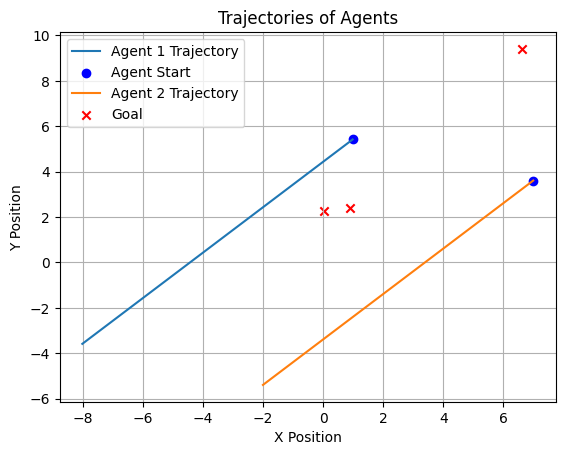

[[[-0.02313641  5.9908836 ]
  [-1.02313642  4.99088359]
  [-2.02313643  3.99088358]
  [-3.02313644  2.99088357]
  [-4.02313645  1.99088356]
  [-5.02313646  0.99088355]
  [-6.02313647 -0.00911646]
  [-7.02313648 -1.00911647]
  [-8.02313649 -2.00911648]
  [-9.02313649 -3.00911649]
  [-9.02313649 -3.00911649]]

 [[ 4.41476243  2.60584076]
  [ 3.41476242  1.60584075]
  [ 2.41476241  0.60584074]
  [ 1.41476241 -0.39415927]
  [ 0.4147624  -1.39415928]
  [-0.58523761 -2.39415929]
  [-1.58523762 -3.3941593 ]
  [-2.58523763 -4.39415931]
  [-3.58523764 -5.39415932]
  [-4.58523765 -6.39415933]
  [-4.58523765 -6.39415933]]]


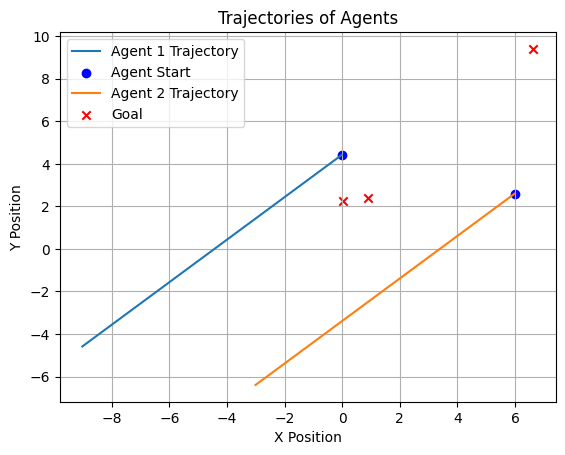

In [81]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

def softmin_casadi(x, alpha=1):
    return -1 / alpha * ca.log(ca.sum1(ca.exp(-alpha * x + 1e-17)))

def softmax_casadi(x, alpha=1):
    return ca.exp(-alpha * x) / ca.sum1(ca.exp(-alpha * x))

def continuous_max (x, alpha=1):
    return 1 / alpha * ca.log(ca.sum1(ca.exp(alpha * x + 1e-17)))

def compute_distance(robot_position, goal_positions):
    return ca.sqrt(ca.sum1((robot_position - goal_positions) ** 2)).T

def compute_evidence(robot_position, goal_positions, eta=10):
    evidence = compute_distance(robot_position, goal_positions)
    return eta * ca.exp(-1.0 / eta * evidence)

def compute_entropy(evidence):
    likelihood = softmax_casadi(evidence)
    total_cost = -ca.mtimes(likelihood.T, ca.log(likelihood))
    return total_cost * 1e3

def system_dynamics(x, u):
    return x + u * time_step

def multi_agent_rhc_free_energy(params, maximum_distance=10):
    # Parse parameters
    num_agents = params['num_agents']
    state_dim = params['state_dim']
    prediction_horizon = params['horizon']
    time_step = params['time_step']
    num_goals = params['goal_positions'].shape[0]
    min_distance = params['min_distance']
    max_velocity = params['max_velocity']

    opti = ca.Opti()
    X = [[opti.variable(state_dim) for _ in range(prediction_horizon + 1)] for _ in range(num_agents)]
    U = [[opti.variable(state_dim) for _ in range(prediction_horizon)] for _ in range(num_agents)]

    X_ref = opti.parameter(state_dim, num_goals)
    X_init = opti.parameter(state_dim, num_agents)
    total_cost = 0
    evidence = ca.MX.zeros(num_goals,num_agents)

    for k in range(prediction_horizon):
        for i in range(num_agents):
            if k == 0:
                opti.subject_to(X[i][0] == X_init[:,i])
            opti.subject_to(X[i][k + 1] == system_dynamics(X[i][k], U[i][k]))
            evidence[:,i] += compute_evidence(X[i][k], X_ref, maximum_distance)
            for dim in range(state_dim):
                opti.subject_to(U[i][k][dim] <= max_velocity)
                opti.subject_to(U[i][k][dim] >= -max_velocity)
            total_cost += ca.sumsqr(U[i][k])
        total_cost += compute_entropy(ca.sum2(evidence))

    for i in range(num_agents):
        # Add a soft constraint to ensure the robot attempts to reach its believed goal (need to change this to believed goal rather than closest goal)
        total_cost += continuous_max((maximum_distance - evidence[:,i]))**2 

    for i in range(num_agents):
        for j in range(i + 1, num_agents):
            for k in range(prediction_horizon):
                distance = ca.sqrt(ca.sumsqr(X[i][k] - X[j][k]))
                opti.subject_to(distance >= min_distance)

    opti.minimize(total_cost)

    opts = {
        "ipopt.print_level": 0,
        "print_time": 0,
        "ipopt.tol": 1e-8,
        "ipopt.acceptable_tol": 1e-4,
        "ipopt.acceptable_iter": 10,
        "ipopt.max_iter": 500,
        "ipopt.linear_solver": "mumps"
    }
    opti.solver('ipopt', opts)

    return opti, X_init, X_ref, X, U

def solve_opti(opti, X_init, X_ref, X, U, params):
    #Parse parameters
    reference_states = params['goal_positions']
    initial_states = params['robot_positions']
    num_agents = params['num_agents']
    state_dim = params['state_dim']
    control_dim = state_dim
    prediction_horizon = params['horizon']

    # Set the reference states and initial states
    opti.set_value(X_init, initial_states.T)
    opti.set_value(X_ref, reference_states.T)
    best_value = np.inf
    best_sol = None

    try:
        for i in range(num_agents):
            for k in range(prediction_horizon + 1):
                opti.set_initial(X[i][k], np.random.random_sample((state_dim,)) * 0.1)
        sol = opti.solve()
        sol_value = sol.value(opti.f)
    except RuntimeError as e:
        print(f"Solver failed: {e}")
        sol_value = np.inf

    if sol_value < best_value:
        best_value = sol_value
        best_sol = sol

    if best_value == np.inf:
        print("Solver failed to find a solution.")
        return None, None

    optimal_u = np.zeros((num_agents, control_dim))
    for i in range(num_agents):
        for dim in range(control_dim):
            optimal_u[i][dim] = best_sol.value(U[i][0][dim])

    trajectories = np.zeros((state_dim, prediction_horizon + 1, num_agents))
    for i in range(num_agents):
        for k in range(prediction_horizon + 1):
            for dim in range(state_dim):
                trajectories[dim, k, i] = best_sol.value(X[i][k][dim])

    return optimal_u, trajectories

def plot_trajectories(initial_states, reference_states, trajectories, prediction_horizon, time_step):
    num_agents = initial_states.shape[0]

    fig, ax = plt.subplots()
    for i in range(num_agents):
        ax.plot(trajectories[0, :, i], trajectories[1, :, i], label=f'Agent {i+1} Trajectory')
        ax.scatter(initial_states[i, 0], initial_states[i, 1], c='blue', marker='o', label='Agent Start' if i == 0 else "")
    for i in range(reference_states.shape[0]):
        ax.scatter(reference_states[i, 0], reference_states[i, 1], c='red', marker='x', label='Goal' if i == 0 else "")

    ax.legend()
    ax.set_title('Trajectories of Agents')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    plt.grid(True)
    plt.show()

# Example usage:
num_agents = 2
num_goals = 3
robot_positions = np.random.rand(num_agents, 2) * 10  # Initial positions of two robots
goal_positions = np.random.rand(num_goals, 2) * 10  # Random goal positions
horizon = 10  # Prediction horizon
time_step = 1  # Time step

params = {'robot_positions': robot_positions, 'goal_positions': goal_positions, 'horizon': horizon, 'time_step': time_step, 'num_agents': num_agents, 'state_dim': 2}

opti, X_init, X_ref, X, U = multi_agent_rhc_free_energy(params)

# Control loop
iterations = 2  # Number of iterations to simulate
for _ in range(iterations):
    optimized_u, optimized_trajectory = solve_opti(opti, X_init, X_ref, X, U, params)
    if optimized_trajectory is not None:
        print(optimized_trajectory)
        plot_trajectories(robot_positions, goal_positions, optimized_trajectory, prediction_horizon, time_step)
        robot_positions += optimized_u * time_step
    else:
        print("Optimization failed for this iteration.")
